In [1]:

import os
import sys
import csv
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src.architectures.auto_regressive import SequentialAutoRegressive
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'stock_prediction_lstm')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define the feature and target columns
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

In [3]:
shuffle_data = False # Whether to shuffle the data before splitting
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 3e-4 # Learning rate for the optimizer
batch_size = 64 # Number of samples to use for each batch
epochs = 50 # Number of epochs to train the model
seq_len = 48 # Length of the input sequences
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
def load_data(file_path: str) -> list[dict]:
    """
    Load data from a CSV file.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - data: list[dict], list of dictionaries containing the data
    """
    
    # Read the CSV file
    with open(file_path, 'r') as file:
        # Create a CSV reader object
        reader = csv.DictReader(file)
        
        # Iterate over the rows in the CSV file
        return [row for row in reader]

In [6]:
# Load the data
data = load_data(dataset_path)

In [7]:
# Extract the feature and date columns
absolute_prices = np.array([[np.float32(data[j][k]) for k in feature_columns] for j in range(len(data))])
dates = np.array([data[j]['Date'] for j in range(len(data))])

In [8]:
# Convert the feature prices to log returns to better predict non-stationary data like stock prices
log_returns = np.log(absolute_prices[1:] / absolute_prices[:-1])

# Remove the first date since it doesn't have a corresponding log return
dates_returns = dates[1:]

### Data visualization

In [9]:
def reduce_by_mean(arr: np.ndarray, group_size: int) -> np.ndarray:
    """
    Reduce an array by taking the mean of each group of elements.
    
    Parameters:
    - arr: np.ndarray, input array to reduce
    - group_size: int, size of each group to take the mean of
    
    Returns:
    - np.ndarray, reduced array with the mean of each group
    """
    
    # Extract the shape of the array
    n = len(arr)
    
    # Check if the group size is valid
    if group_size <= 0 or n < group_size:
        # Raise an error if the group size is invalid
        raise ValueError("Group size must be positive and less than or equal to the length of the array.")
    
    # Trim the array to a multiple of the group size
    trimmed_length = n - (n % group_size)
    
    # Reshape the array to group the elements and take the mean of each group
    return arr[:trimmed_length].reshape(-1, group_size).mean(axis=1)

In [10]:
def plot_data(arr: np.ndarray, start_date: str, end_date: str, x_freq: int = 1, freq_locator: Literal["year", "day"] = "year") -> None:
    """
    Plot the given array using matplotlib.
    
    Parameters:
    - arr: np.ndarray, input array to plot
    - start_date: str, start date for the x-axis
    - end_date: str, end date for the x-axis
    - x_freq: int, frequency of the x-axis ticks
    - freq_locator: str, frequency locator for the x-axis ticks ("year" or "day")
    """
    
    # Convert the start and end dates to datetime objects
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the total number of seconds between the start and end dates
    total_seconds = (end_dt - start_dt).total_seconds()
    
    # Calculate the step size in seconds for each element in the array
    step_seconds = total_seconds / (len(arr) - 1)
    
    # Create a list of dates for the x-axis
    dates = np.array([start_dt + timedelta(seconds=i * step_seconds) for i in range(len(arr))])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot the array against the dates
    ax.plot(dates, arr)
    
    # Set the axis labels and title
    ax.set_title('S&P 500')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)
    
    # Set the x-axis major locator and formatter
    locator = mdates.YearLocator(base=x_freq) if freq_locator == "year" else mdates.DayLocator(interval=x_freq)
    formatter = mdates.DateFormatter('%Y') if freq_locator == "year" else mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

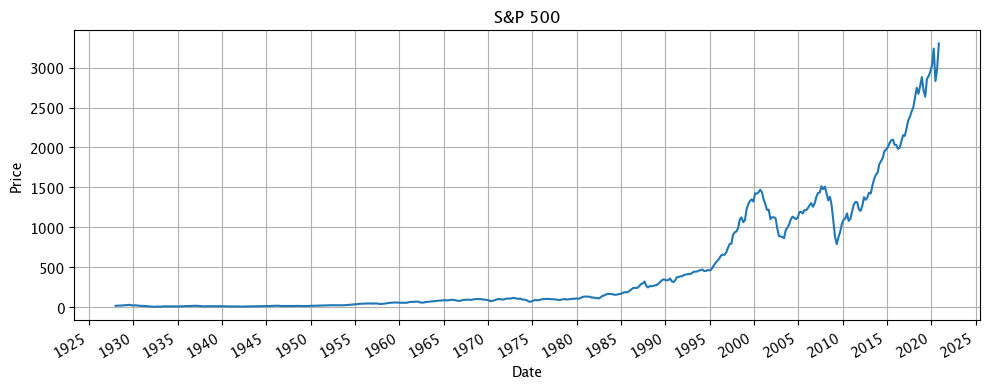

In [11]:
# Reduce the close prices by taking the mean of each group of sequence length
close_prices = reduce_by_mean(absolute_prices[:, close_price_idx], seq_len)

# Plot the reduced close prices
plot_data(close_prices, dates[0], dates[-1], x_freq=5)

### Data preprocessing

In [12]:
def build_sequences(log_returns: np.ndarray, absolute_prices: np.ndarray, seq_length: int) -> tuple[Tensor, Tensor, Tensor]:
    """
    Build sequences of data for training the model.
    
    Parameters:
    - log_returns: np.ndarray, array of log returns
    - absolute_prices: np.ndarray, array of absolute prices
    - seq_length: int, length of the input sequences
    
    Returns:
    - tuple[Tensor, Tensor, Tensor], tuple of input sequences, target values, and previous values
    """
    
    # Create a list to hold the sequences and labels
    x, y = [], []
    
    # Create a list to hold the target absolute price for each sequence
    absolut_prices_y = []
    
    # Iterate over the data to create sequences
    for i in range(seq_length, len(log_returns)):
        # Append the sequence and target to the lists
        x.append(log_returns[i-seq_length:i, :])
        y.append(log_returns[i, :])
        
        # Append the target absolute price to the list
        absolut_prices_y.append(absolute_prices[i, :])

    # Convert the lists to numpy arrays
    return (
        Tensor(np.array(x, dtype=np.float32)),
        Tensor(np.array(y, dtype=np.float32)),
        Tensor(np.array(absolut_prices_y, dtype=np.float32))
    )

In [13]:
# Build sequences of input features and labels
features, targets, absolute_targets = build_sequences(
    log_returns = log_returns,
    absolute_prices = absolute_prices,
    seq_length = seq_len
)

# Split the dataset into training, validation, and testing sets
X_log_returns_train, X_log_returns_test, y_log_returns_train, y_log_returns_test = data_processing.split_data((features, targets), train_test_split_pct, shuffle=shuffle_data)
X_log_returns_train, X_log_returns_valid, y_log_returns_train, y_log_returns_valid = data_processing.split_data((X_log_returns_train, y_log_returns_train), train_valid_split, shuffle=shuffle_data)

# Splt the previous values into training, validation, and testing sets
y_absolute_prices_train, y_absolute_prices_test = data_processing.split_data(absolute_targets, train_test_split_pct, shuffle=shuffle_data)
y_absolute_prices_train, y_absolute_prices_valid = data_processing.split_data(y_absolute_prices_train, train_valid_split, shuffle=shuffle_data)

# Print the dataset information
print('Training set:', X_log_returns_train.shape(), y_log_returns_train.shape())
print('Validation set:', X_log_returns_valid.shape(), y_log_returns_valid.shape())
print('Testing set:', X_log_returns_test.shape(), y_log_returns_test.shape())

Training set: (14896, 48, 4) (14896, 4)
Validation set: (3724, 48, 4) (3724, 4)
Testing set: (4654, 48, 4) (4654, 4)


## Data normalization

In [14]:
def compute_normalization_stats(X: Tensor) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    Computes the mean and standard deviation for each feature across all samples and all time steps.

    Parameters:
    - X (Tensor): Input data of shape (N, T, F), where N is the number of samples,

    Returns:
    - mean (Tensor): Mean of each feature across all samples and time steps.
    - std (Tensor): Standard deviation of each feature across all samples and time steps.
    - min (Tensor): Minimum value of each feature across all samples and time steps.
    - max (Tensor): Maximum value of each feature across all samples and time steps.
    """
    
    # Compute the mean and standard deviation for each feature
    mean = X.to_numpy().mean(axis=(0, 1))
    std = X.to_numpy().std(axis=(0, 1))
    min = X.to_numpy().min(axis=(0, 1))
    max = X.to_numpy().max(axis=(0, 1))
    
    # Return the mean and standard deviation
    return (
        Tensor(mean, dtype=np.float32),
        Tensor(std, dtype=np.float32),
        Tensor(min, dtype=np.float32),
        Tensor(max, dtype=np.float32)
    )

In [15]:
def min_max_normalization(X: Tensor, min: Tensor, max: Tensor) -> Tensor:
    """
    Applies min-max normalization using precomputed min and max.

    Parameters:
    - X (Tensor): Input tensor of shape (N, T, F)
    - min (Tensor): Feature-wise min, shape (F,)
    - max (Tensor): Feature-wise max, shape (F,)
    
    Returns:
    - Tensor: Normalized array of the same shape as X
    """
    
    # Return a new Tensor object with the normalized data
    return (X - min) / (max - min)


def min_max_denormaliation(X: Tensor, min: Tensor, max: Tensor) -> Tensor:
    """
    Applies min-max denormalization using precomputed min and max.

    Parameters:
    - X (Tensor): Input tensor of shape (N, T, F)
    - min (Tensor): Feature-wise min, shape (F,)
    - max (Tensor): Feature-wise max, shape (F,)
    
    Returns:
    - Tensor: Denormalized array of the same shape as X
    """
    
    # Return a new Tensor object with the denormalized data
    return X * (max - min) + min

In [16]:
# Compute normalization statistics for the training data
mean, std, min, max = compute_normalization_stats(X_log_returns_train)

# Print the normalization statistics
print('Normalization statistics:')
print('Mean:', mean.to_numpy())
print('Std:', std.to_numpy())
print('Min:', min.to_numpy())
print('Max:', max.to_numpy())

# Normalize the features
X_log_returns_train_normalized = min_max_normalization(X_log_returns_train, min, max)
X_log_returns_valid_normalized = min_max_normalization(X_log_returns_valid, min, max)
X_log_returns_test_normalized = min_max_normalization(X_log_returns_test, min, max)

# Normalize the targets
y_log_returns_train_normalized = min_max_normalization(y_log_returns_train, min, max)
y_log_returns_valid_normalized = min_max_normalization(y_log_returns_valid, min, max)

Normalization statistics:
Mean: [0.00019245 0.00019283 0.00019217 0.0001926 ]
Std: [0.01209214 0.01205279 0.01213088 0.01212412]
Min: [-0.13857588 -0.13857588 -0.13857588 -0.13857588]
Max: [0.1536613 0.1536613 0.1536613 0.1536613]


### Building the model

In [17]:
# Instantiating the model
model = SequentialAutoRegressive(
    name = "Stock prediction model",
    sequence_length = seq_len,
    modules = [
        layers.LSTM(num_layers=2, num_units=64, dropout=0.1),
        layers.LayerNormalization(),
        layers.Dense(num_units=X_log_returns_train_normalized.shape()[-1]),
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [18]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    out = model(X_log_returns_train_normalized[:batch_size])

In [19]:
# Display the model summary
model.summary(recursive=True)

Stock prediction model (SequentialAutoRegressive) [output_shape=(64, 4), params=51588]
└── stock_prediction_model.modules (ModuleList) [output_shape=(64, 4), params=51588]
    ├── module_list.0 (LSTM) [output_shape=(64, 64), params=51200]
    │   └── lstm.dropout_layer (Dropout) [output_shape=(64, 64), params=0]
    ├── module_list.1 (LayerNormalization) [output_shape=(64, 64), params=128]
    └── module_list.2 (Dense) [output_shape=(64, 4), params=260]


### Training the model

In [20]:
history = model.fit(
    X_train = X_log_returns_train_normalized,
    y_train = y_log_returns_train_normalized,
    X_valid = X_log_returns_valid_normalized,
    y_valid = y_log_returns_valid_normalized,
    epochs = epochs,
    loss_fn = loss_fn,
    optimizer = optimizer,
    batch_size = batch_size,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/50 --> loss: 0.012184 - mean absolute error: 0.069543 | Valid loss: 0.0013833 - Valid mean absolute error: 0.024903            
Epoch 2/50 --> loss: 0.0027048 - mean absolute error: 0.037251 | Valid loss: 0.0012999 - Valid mean absolute error: 0.023933            
Epoch 3/50 --> loss: 0.002049 - mean absolute error: 0.030672 | Valid loss: 0.001304 - Valid mean absolute error: 0.023929            
Epoch 4/50 --> loss: 0.0019012 - mean absolute error: 0.02877 | Valid loss: 0.0012911 - Valid mean absolute error: 0.023918            
Epoch 5/50 --> loss: 0.0018478 - mean absolute error: 0.028033 | Valid loss: 0.0012878 - Valid mean absolute error: 0.023719            
Epoch 6/50 --> loss: 0.0018088 - mean absolute error: 0.027538 | Valid loss: 0.0013173 - Valid mean absolute error: 0.024214            
Epoch 7/50 --> loss: 0.0018001 - mean absolute error: 0.027352 | Valid loss: 0.0013066 - Valid mean absolute error: 0.024312            
Epoch 8/50 --> loss: 0.0017731 - mean absolut

In [21]:
# Save the model
model.save(model_path)

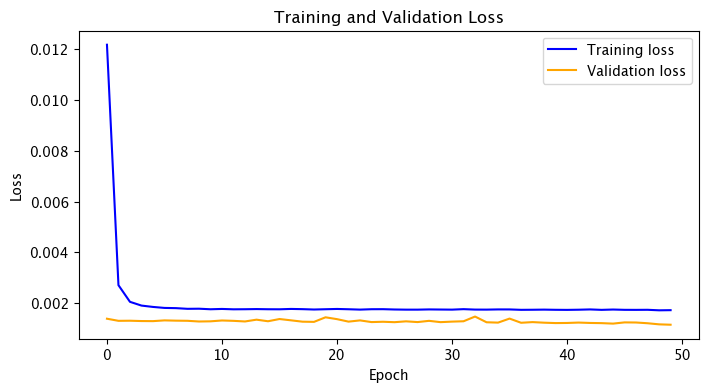

In [22]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = model.history["loss"], 
    valid_loss = model.history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch",
    ylabel = "Loss"
)

### Evaluation

In [23]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    log_returns_preds = model(X_log_returns_test_normalized)

In [24]:
# Denormalize the predictions
log_returns_preds = min_max_denormaliation(log_returns_preds, min, max)

# Extract only the close prices from the predictions and the true values of the log returns
close_prices_log_returns_preds = log_returns_preds[:, close_price_idx]
close_prices_log_returns_true = y_log_returns_test[:, close_price_idx]

# Calculate the mean absolute error
log_returns_mae = metrics.mean_absolute_error(close_prices_log_returns_preds, close_prices_log_returns_true)

In [25]:
# Compute the absolute prices from the predictions
absolute_prices_preds = y_absolute_prices_test * log_returns_preds.exp()
absolute_prices_true = y_absolute_prices_test * y_log_returns_test.exp()

# Extract only the close prices from the predictions and the true values of the absolute prices
close_prices_absolute_preds = absolute_prices_preds[:, close_price_idx]
close_prices_absolute_true = absolute_prices_true[:, close_price_idx]

# Calculate the mean absolute error
absolute_prices_mae = metrics.mean_absolute_error(close_prices_absolute_preds, close_prices_absolute_true)

In [26]:
# Print the inference results
print("Mean Absolute Error (on log returns):", log_returns_mae.to_numpy())
print("Mean Absolute Error (on absolute prices):", absolute_prices_mae.to_numpy())

Mean Absolute Error (on log returns): 0.0079777725
Mean Absolute Error (on absolute prices): 12.645361


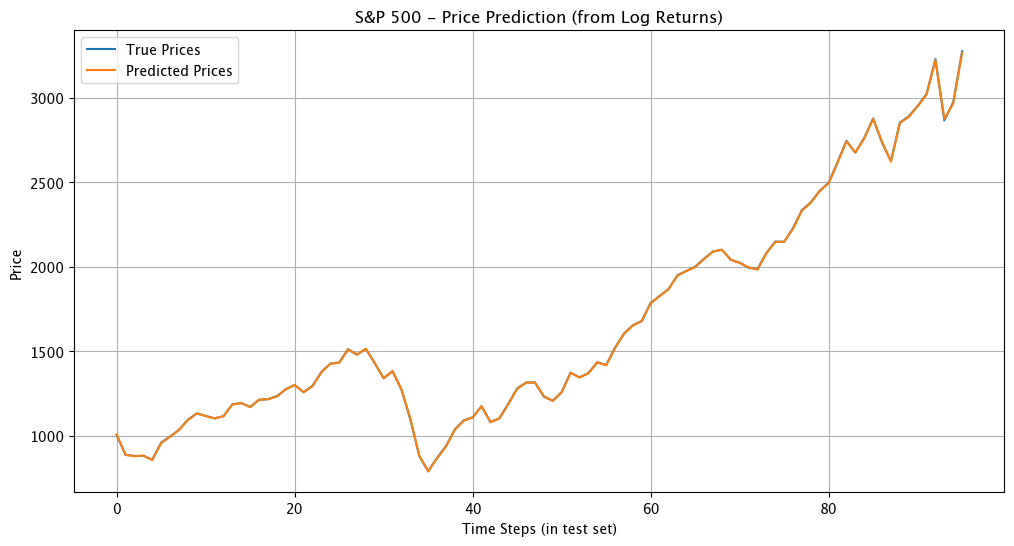

In [27]:
# Plot the true and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(reduce_by_mean(close_prices_absolute_true.to_numpy().flatten(), seq_len), label='True Prices')
plt.plot(reduce_by_mean(close_prices_absolute_preds.to_numpy().flatten(), seq_len), label='Predicted Prices')
plt.title('S&P 500 - Price Prediction (from Log Returns)')
plt.xlabel('Time Steps (in test set)')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

### Inference

In [28]:
# Define the number of steps to generate and
# take a random sequence from the features set
num_generation_steps = 8
idx = np.random.randint(1, len(X_log_returns_test_normalized.data) - 1)

# Extract the full sequence from the test set
test_sequence = X_log_returns_test_normalized[idx:idx+1]

# Autoregressive generation
out_seq = model.autoregressive_generation(x=test_sequence, num_steps=num_generation_steps)

# If the output is a generator, convert it to a Tensor
# Then, concatenate the original sequence with the generated sequence
# and finally, denormalize it
out_seq = model.concat_generation(out_seq) if not isinstance(out_seq, Tensor) else out_seq
out_seq = Tensor.concat([test_sequence, out_seq], axis=1)
out_seq = min_max_denormaliation(out_seq, min, max)

# Extract the absolute prices from the generated sequence
seed_abs_price = y_absolute_prices_test[idx - 1] if idx > 0 else y_absolute_prices_test[0]

# Create an initial list to hold the absolute prices
abs_price_out_seq = [seed_abs_price]

# Iterate over the generated log returns and compute the absolute prices
for step_log_ret in out_seq[0]:
    # Compute the next absolute price using the last absolute price and the generated log return
    next_price = abs_price_out_seq[-1] * step_log_ret.exp()
    
    # Append the next absolute price to the list
    abs_price_out_seq.append(next_price)

# Stack the absolute prices into a single tensor
generated_abolute_prices = Tensor.stack(abs_price_out_seq[1:], axis=0)

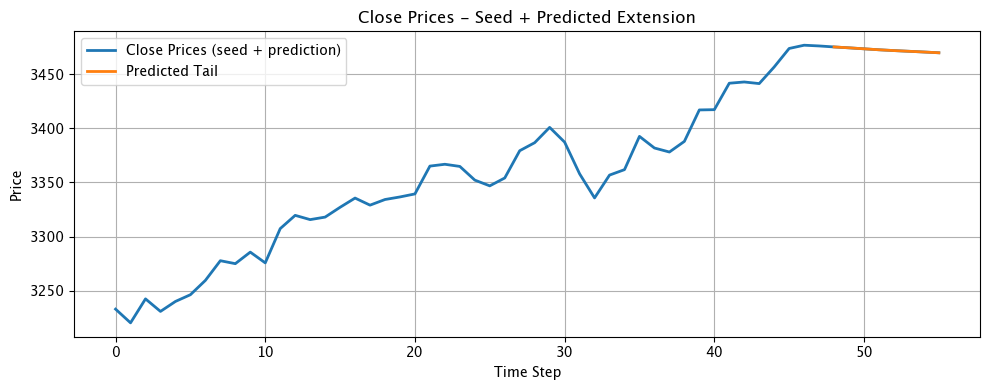

In [29]:
# Extract the close prices from the generated absolute prices
close_prices = generated_abolute_prices[:, close_price_idx].to_numpy()

# Create a figure for the plot
plt.figure(figsize=(10, 4))

# Plot all the series of close prices
plt.plot(close_prices, label='Close Prices (seed + prediction)', linewidth=2)

# Plot and highlight only the generated part
start_pred = len(close_prices) - num_generation_steps
plt.plot(
    range(start_pred, len(close_prices)),
    close_prices[start_pred:],
    label = 'Predicted Tail',
    linewidth = 2,
)

# Show the plot
plt.title('Close Prices - Seed + Predicted Extension')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()